In [453]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import scipy.stats as stats
from scipy import interp
import statistics 
import sklearn

from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneOut 

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from imblearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier

# other tools
from functools import reduce
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN # doctest: +NORMALIZE_WHITESPACE
import itertools
import copy

import warnings
warnings.filterwarnings('ignore') 
# show plots inline
%matplotlib inline

In [454]:
np.random.seed(100)

## 0. Load data

In [455]:
df0 = pd.read_csv('Depression Project Part 2.csv')
df = df0.copy(deep=True)
df.head()

,mental illness,gender,age,family income,education,military,HH food security,health conditions,health compared to a year ago,visit to mental pro,...,non-family house,family house,home owned,rented home,home:other,Mexican American,Other Hispanic,Non-Hispanic White,Non-Hispanic Black,Other/Multi-racial
0,0,1.0,1.307598,11.0,3.0,1.0,1.0,4.0,3.0,0.0,...,0,1,1,0,0,0,0,1,0,0
1,0,0.0,-1.107360,6.0,1.0,0.0,1.0,1.0,3.0,0.0,...,1,0,0,1,0,1,0,0,0,0
2,1,0.0,1.480095,5.0,2.0,0.0,3.0,4.0,2.0,0.0,...,1,0,0,1,0,0,0,0,1,0
3,0,1.0,1.307598,6.0,3.0,0.0,1.0,1.0,1.0,0.0,...,0,1,1,0,0,1,0,0,0,0
4,0,1.0,-0.417372,5.0,3.0,0.0,2.0,2.0,1.0,0.0,...,1,0,0,1,0,0,0,0,1,0


## 1. Split data into train / val / test sets

* Split all data into two sets: train + val & test
    * Split train + val into train & val in all later executions
    * Hold out test sets for final evaluation after tuning the models (test sets are not seen anywhere until the last step)

### 1.1 Holdout: k = 1

* The result of a simple train/test split could be not random, which will result in overfitting. We need to create validation sets and perform cross validations

In [456]:
def holdout(X_train_val, y_train_val, test_size):
    print('holdout split')
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2,random_state = 2)
    return X_train, X_val, y_train, y_val

### 1.2 K-fold: k = k

* Cross validation:

    1. K fold: 
        * For classification problems, stratified sampling is recommended for creating the folds. Each response class should be represented with equal proportions in each of the K fold. Each cross-validation fold should consist of exactly 20% db. Scikit-learn's cross_val_score function does stratified sampling by default. StratifiedKFold - different from oversampling issue. 
        * Need to perform SMOTE within each fold. Accordingly, you need to avoid train_test_split in favour of KFold(set the value for the test_size parameter to 0 if want to call fn above). Perform oversampling during cross-validation, i.e. for each fold, oversampling is performed before training, and this process is repeated for each fold
    2. Leave one out
          * K-fold cross validation taken to its logical extreme, with K equal to N, the number of data points in the set


In [477]:
def ppipeline(X_train_val, y_train_val, clf, param_grid):
    sm = SMOTE(random_state=42)
    pca = PCA(0.95)
    pipe = make_pipeline(sm,pca,clf)
#     pipe = Pipeline([
#                         ('smote',SMOTE(random_state=42)),
#                         ('pca',PCA(0.95)),
#                         ('clf',clf)
#                         ])
    
    cv = StratifiedKFold(n_splits=10,random_state=0,shuffle=True)
    
    gs = GridSearchCV(estimator = pipe,
                      param_grid = param_grid,
                      scoring = 'accuracy',
                      cv = cv)
    
    
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2,random_state = 2)
    gs.fit(X_train, y_train)
    print('gs Test accuracy: %.3f' % gs.score(X_val, y_val))
    predictions=grid_search.predict(X_val)
    print('accuracy',accuracy_score(y_val,predictions))
    print('precision',precision_score(y_val,predictions))
    print('recall',recall_score(y_val,predictions))

    best_parameters = dict(gs.best_estimator_.get_params())#get实例中的最优参数
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))#输出最有参数结果

    
    print('check if the clfs are the same')
    best_clf = gs.best_estimator_
    print('best clf Test accuracy: %.3f' % best_clf.score(X_val, y_val))

    print(gs)
    print(best_clf)
    


In [458]:
# default: Stratification, SMOTE, PCA
def kfold(X_train_val, y_train_val, clf, paramanalysis): 

    cv = StratifiedKFold(n_splits=10,random_state=0,shuffle=True)
    
    tprs, aucs = [],[]
    val_accuracies = []
    if analysis == True:
        fig, ax = plt.subplots(figsize=(12,8))
    
    sm = SMOTE(random_state=42)
    pca = PCA(0.95)
    
    
    for i, (train_index, val_index) in enumerate(cv.split(X_train_val, y_train_val)):
        X_train, X_val, y_train, y_val = X_train_val[train_index], X_train_val[val_index], y_train_val[train_index], y_train_val[val_index]
        best_clf = grid_search_cv(X_train, y_train, clf, param_grid)
        pipeline = make_pipeline(sm,pca,best_clf)
        y_val_pred, accuracy, fitted_clf = get_predictions(X_train, X_val, y_train, y_val, pipeline)
        val_accuracies.append(accuracy)

        if analysis == True:
            tpr, auc = roc_one_fold(fitted_clf, X_val, y_val, i, ax)
            tprs.append(tpr)
            aucs.append(auc)
        
    val_mean_accuracy = statistics.mean(val_accuracies)
    val_std = statistics.stdev(val_accuracies)

    print(val_accuracies)
    print('val Mean accuracy:',val_mean_accuracy) 
    print('val std:',val_std) 

    if analysis == True: roc_all_folds_mean(ax, tprs, aucs)
    print(classification_report(y_val, y_val_pred))



In [459]:
def roc_one_fold(fitted_clf, X_val, y_val, i, ax):
    mean_fpr = np.linspace(0, 1, 100)
    viz = metrics.plot_roc_curve(fitted_clf, X_val, y_val, name='ROC fold {}'.format(i), alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tpr = interp_tpr
    auc = viz.roc_auc
    return tpr, auc
       
def roc_all_folds_mean(ax, tprs, aucs):
    mean_fpr = np.linspace(0, 1, 100)
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc), lw=2, alpha=.8)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')
    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05], title="Receiver operating characteristic example")
    ax.legend(loc="lower right")
    plt.show()


### 1.3 Leave one out: k = N

In [460]:
def leave_one_out(X_train_val, y_train_val, clf):
    loo = LeaveOneOut()
    loo.get_n_splits(X_train_val)
    
    val_accuracies = []
    for train_index, val_index in loo.split(X_train_val):
        X_train, X_val, y_train, y_val = X_train_val[train_index], X_train_val[val_index], y_train_val[train_index], y_train_val[val_index]
        X_train, X_val, y_train, y_val = implement_SMOTE(X_train, X_val, y_train, y_val)
        y_val_pred, accuracy, fitted_clf = get_predictions(X_train, X_val, y_train, y_val, clf)
        val_accuracies.append(accuracy)
        
    val_mean_accuracy = statistics.mean(val_accuracies)
    val_std = statistics.stdev(val_accuracies)
    print('val Mean accuracy:',val_mean_accuracy) 
    print('val std:',val_std) 


## 2. Oversample [y] - SMOTE

The dependent variable 'mental illness' is imbalanced. If we train a model without fixing this problem, the model will be completely biased.

0    1244
1     124
Name: mental illness, dtype: int64

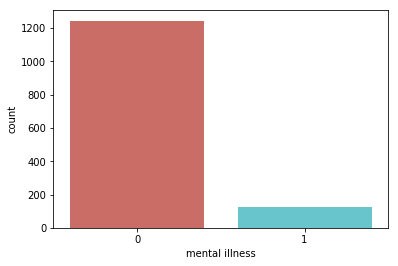

In [461]:
sns.countplot(x="mental illness",data=df0,palette='hls')
df['mental illness'].value_counts()

* ### SMOTE
SMOTE (Synthetic Minority Over-sampling Technique). In simple terms, it looks at the feature space for the minority class data points and considers its k nearest neighbours. If we don't deal with the disproportionate ratio, the model will consider mental illness samples (~20%) as trivial and predict them as healthy. If so, the model can still have high accuracy (~0.8) but it's fake accuracy 
* training set expands after oversampling
* SMOTE performs the following steps:
    * Finding the k-nearest-neighbors for minority class observations (finding similar observations)
    * Randomly choosing one of the k-nearest-neighbors and using it to create a similar, but randomly tweaked, new observations.


In [462]:
def implement_SMOTE(X_train, X_val, y_train, y_val):
    sm = SMOTE(random_state=42)
    X_train_oversampled, y_train_oversampled = sm.fit_sample(X_train, y_train.ravel())
#     sme = SMOTEENN(random_state=42)
#     X_train_oversampled, y_train_oversampled = sme.fit_resample(X_train, y_train.ravel())
    
#     print('Before OverSampling: yes mental illness - ', sum(y_train==1),'   no mental illness - ',sum(y_train==0))
#     print('After OverSampling:  yes mental illness - ', sum(y_train_oversampled==1),'  no mental illness - ',sum(y_train_oversampled==0))
    return X_train_oversampled, X_val, y_train_oversampled, y_val

* note:
- If set parameter class_weight = 'balanced' in sklearn models, 会按照比例调整比较多的类别的样本的权重降低，比较少样本的类别的样本权重依比提高。-> same as using SMOTE???
- Result comparison for logistic regression (holdout split): 
    - SMOTE
        - Validation set accuracy: 0.846
        - Training set accuracy: 0.829
    - SMOTE + class_weight = balanced
        - Validation set accuracy: 0.846
        - Training set accuracy: 0.829
    - NO SMOTE; class_weight  = balanced 
        - Validation set accuracy: 0.842
        - Training set accuracy: 0.830
    - Nothing 
        - Validation set accuracy: 0.892
        - Training set accuracy: 0.908

## 3. Tune parameters

### Hyper-parameters
* n_estimators: default = 100, overfitting if too big
* oob_score=False :即是否采用袋外样本来评估模型的好坏。默认是False。推荐设置为True，因为袋外分数反应了一个模型拟合后的泛化能力。

### Grid Search CV
* Grid search implements cross validation on default. The goal is to find the best combination of hyperparameters. one combination = one grid, each grid corresponds to a model, then select the one that performs the best. 
* Pass only train data to grid search. Grid search will split this train data further into train and test to tune the hyper-parameters passed to it. And finally fit the model on the whole train data with best found parameters.
* best_clf: Actual model object fit with those best parameters. Shows default parameters that we did not specify

Say in first iteration n_estimators = 100 and max_depth = 4 is selected for model building.Now will the score for this model be choosen with the help of 10 fold cross-validation ?
    
        a. My understanding about the process is as follows
        1.X_train and y_train will be splitted in to 10 sets.
        Model will be trained on 9 sets and tested on 1 remaining set and its score will be stored in a list: say score_list
        This process will be repeated 9 more times and each of this 9 scores will be added to the score_list to give 10 score in all
        Finally the average of the score_list will be taken to give a final_score for the model with parameters :n_estimators = 100 and max_depth = 4
        b. The above process will repeated with all other possible combinations of n_estimators and max_depth and each time we will get a final_score for that model
        c. The best model will be the model having highest final_score and we will get corresponding best values of 'n_estimators' and 'max_depth' by CV_rfc.best_params_

In [463]:
def grid_search_cv(X_train, y_train, clf, param_grid):
    cv = StratifiedKFold(n_splits=10,random_state=0,shuffle=True)
    gs = GridSearchCV(estimator = clf,
                      param_grid = param_grid,
                      scoring = 'accuracy',
                      cv = cv)
    gs = gs.fit(X_train, y_train)
    best_clf = gs.best_estimator_
    print("Best Parameters: {}".format(gs.best_params_))
    # Mean cross-validated score of the best_estimator, not accuracy
    print("Score for the best estimator: {}".format(gs.best_score_)) 
    print('Best estimator:')
    print(best_clf)
    return best_clf

### Random search CV
* This is a close cousin to GridSearchCV
* Searching many different parameters at once may be computationally infeasible
* For example
    - Searching 10 parameters (each range of 1000)
        - Require 10,000 trials of CV
        - 100,000 model fits with 10-fold CV
        - 100,000 predictions with 10-fold CV
* RandomizedSearchCV searches a subset of the parameters
* Specify a continuous distribution (rather than a list of values) for any continous parameters

In [464]:
# specify "parameter distributions" rather than a "parameter grid"
def random_search_cv(X_train, y_train, clf, param_dist):

    # n_iter controls the number of searches/random combinations it will try
    rs = RandomizedSearchCV(clf, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
    rs = rs.fit(X_train, y_train)
    best_clf = rs.best_estimator_
    
    print("Best Parameters: {}".format(rs.best_params_))
    print("Score for the best estimator: {}".format(rs.best_score_)) 
    print('Best estimator:')
    print(best_clf)
    return best_clf


## 4. Analysis

        # probability = clf.predict_proba(X_val)[:, 1] 
        
- Probability of having mental illness for each participant. What is threshold for the probability above which we classify as having mental illness? It seems reasonable, at least at first, to take the threshold to be 0.5. Use ROC to visualize how the performance of the classifier changes as we vary the threshold.
- threshold = 0: all participants are classified as having mental illness. No false negatives (FN: have db but classified as healthy) - recall/TPR = 1. No true negatives (TN: healthy classified as healthy) - FPR = 1 -> TOP RIGHT OF THE ROC CURVE
- threshold = 1: BOTTOM LEFT OF THE ROC CURVE
- TP rate is 1 and the FP rate is 0 — that is, no mental illness patients are classified as healthy people and no healthy people are classified as mental illness patients. This is the point of perfect classification.
                    


### ROC:
* Shows tradeoff between sensitivity and specificity
* AUC: AUC = 1 -> perfect classifier; AUC = 0.5 -> worthless classifier

In [465]:
def roc(tpr,fpr,auc):
    print('AUC:', auc)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate - False alarm')
    plt.ylabel('True Positive Rate - Recall')
#     plt.title(clf_name + '  --  AUC: = %0.2f' % auc)
    plt.legend(['ROC','Completely random'],loc="lower right")
    plt.show()

In [466]:
def plot_roc(y_val,y_val_predictions,clf_name,probability):
    roc_auc = roc_auc_score(y_val, y_val_predictions)
    print('AUC: = %0.2f' % roc_auc)
    fpr, tpr, thresholds = roc_curve(y_val, probability)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate - False alarm')
    plt.ylabel('True Positive Rate - Recall')
#     plt.title(clf_name + '  --  AUC: = %0.2f' % roc_auc)
    plt.legend(['ROC','Completely random'],loc="lower right")
    plt.show()

In [467]:
def plot_confusion_matrix(y_val, y_val_predictions):
    cm = metrics.confusion_matrix(y_val, y_val_predictions)

    class_names=[0,1] 
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

* Function feature_importance can be used for models based on decision tree (random forest)
* Feature importance rates how important each feature is for the decision a tree makes. It is a number between 0 and 1 for each feature, where 0 means “not used at all” and 1 means “perfectly predicts the target”. The feature importances always sum to 1:

In [468]:
# Create a series with feature importances:
def feature_importance(fitted_clf,X_names):
    featimp = pd.Series(fitted_clf.feature_importances_, index=X_names).sort_values(ascending=False)
    print('feature importance')
    print(featimp)
    sns.barplot(x=featimp, y=featimp.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features")
    plt.show()

In [469]:
def get_analysis(X_val, y_val, y_val_pred, clf_name, fitted_clf):
#     # confusion matrix
#     plot_confusion_matrix(y_val, y_val_pred)
    
#     # ROC - AUC
#     if clf_name == 'linear SVC': # linear SVC has no predict_proba
#         pass                  
#     else: 
#         probability = fitted_clf.predict_proba(X_val)[:, 1] 
#         plot_roc(y_val,y_val_pred,clf_name,probability)
    
    print(classification_report(y_val, y_val_pred))


## 5. MAIN

In [470]:
def get_predictions(X_train, X_val, y_train, y_val, clf):
    fitted_clf = clf.fit(X_train,y_train)  
    y_val_pred = fitted_clf.predict(X_val)             # y_val_predictions
    accuracy = fitted_clf.score(X_val, y_val)          # y_val_accuracy
    return y_val_pred, accuracy, fitted_clf

## Principal component analysis
variances = [1,0.99,0.95,0.9,0.85] were tried for the retained_variance variable. It was found that at 0.95, val accuracy is the best (see number)

In [471]:
def main(df, clf_name, clf, param_grid, split_method, stratified, PCA, analysis):
    print(clf_name)
    if split_method == 'holdout':
        X_train, X_val, y_train, y_val = holdout(X_train_val, y_train_val, test_size=0.2)
        X_train, X_val, y_train, y_val = implement_SMOTE(X_train, X_val, y_train, y_val)
                
        if param_grid == None: best_clf = clf
        else: best_clf = grid_search_cv(X_train, y_train, clf, param_grid)
                
        if PCA == True: X_train, X_val = principal_component_analysis(X_train,X_val)
        else: pass

        y_val_pred, accuracy, fitted_clf = get_predictions(X_train, X_val, y_train, y_val, best_clf)
        print()
        print('Validation set accuracy:', accuracy)

        if analysis == True: get_analysis(X_val, y_val, y_val_pred, clf_name, fitted_clf)
        else: pass
        

    elif split_method == 'kfold':
        kfold(X_train_val, y_train_val, clf, analysis)
    
    elif split_method == 'LOO':
        leave_one_out(X_train_val, y_train_val, clf)
    
    else: print('split_method is not defined...')
    
#         if clf_name == 'random forest': feature_importance(fitted_clf,X_names)
#         else: pass

???? if PCA=True for lasso_x, nof changes in each loop in kfold. why???

In [472]:
def principal_component_analysis(X_train,X_val):
    retained_variance = 0.95  # 95% of the variance is retained
    pca = PCA(retained_variance)
    pca.fit(X_train)
    
    X_train = pca.transform(X_train)
    X_val = pca.transform(X_val)
    return X_train, X_val


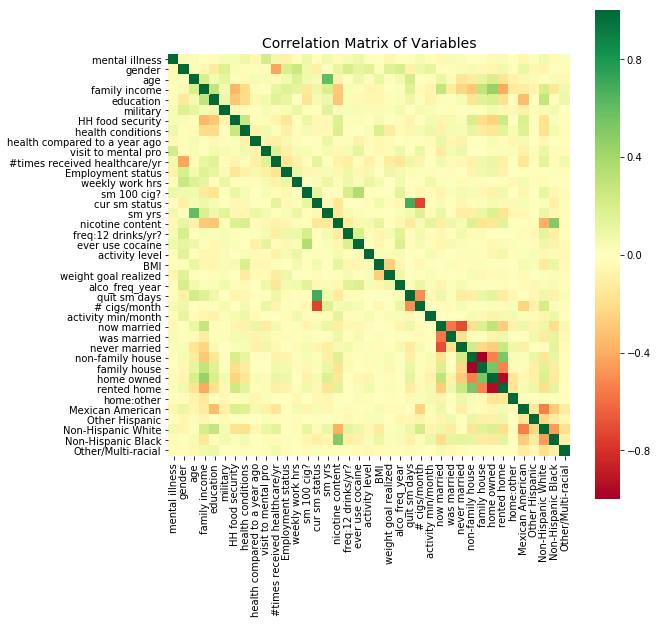

In [473]:
corMat1 = df.corr()
pic3 = plt.subplots(figsize=(9, 9))
sns.heatmap(corMat1, annot=False, vmax=1, square=True, cmap="RdYlGn")
plt.title('Correlation Matrix of Variables', fontsize=14)
plt.show()

# RUN


In [474]:
lasso_eliminated = ['mental illness','gender','age','military','cur sm status','activity level','was married',
                    'never married','non-family house','family house','home owned','home:other',
                    'Other Hispanic', 'Non-Hispanic White','Non-Hispanic Black','Other/Multi-racial']
  
y = df['mental illness'].values
X = df.drop(lasso_eliminated,axis = 1).values
X_names = df.drop(lasso_eliminated,axis = 1).columns
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)



In [475]:
df['mental illness'].mean()

0.09064327485380116

9.06% people have mental illness, which means you could get 91% accuracy by always predicting no/0/healthy. Accuracy should be higher than this. 

In [478]:
clf = LogisticRegression(dual = False, solver = 'liblinear')
param_grid = dict(clf__penalty = ['l1','l2'],
                  clf__C = np.logspace(-5, 8, 15))
# param_grid = {'penalty': ['l1','l2'],
#               'C': np.logspace(-5, 8, 15)}
# logreg = grid_search_cv(X_train, y_train, clf, param_grid)
# logreg = LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
#                             intercept_scaling=1, l1_ratio=None, max_iter=100,
#                             multi_class='auto', n_jobs=None, penalty='l1',
#                             random_state=None, solver='liblinear', tol=0.0001, verbose=0,
#                             warm_start=False)
ppipeline(X_train_val, y_train_val, clf, param_grid)

ValueError: Invalid parameter clf for estimator Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=42, ratio=None,
                       sampling_strategy='auto', svm_estimator='deprecated')),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.95,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='liblinear', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False). Check the list of available parameters with `estimator.get_params().keys()`.

logistic regression
Pipeline: 
val Mean accuracy: 0.6608423686405338
AUC: 0.6615413250059455


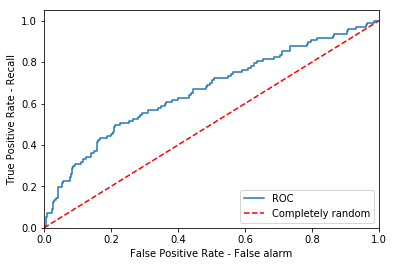


logistic regression
stratified kfold
[0.7090909090909091, 0.6909090909090909, 0.7090909090909091, 0.5727272727272728, 0.6788990825688074, 0.6422018348623854, 0.7247706422018348, 0.5871559633027523, 0.6513761467889908, 0.6422018348623854]
val Mean accuracy: 0.6608423686405338
val std: 0.05158727770831341


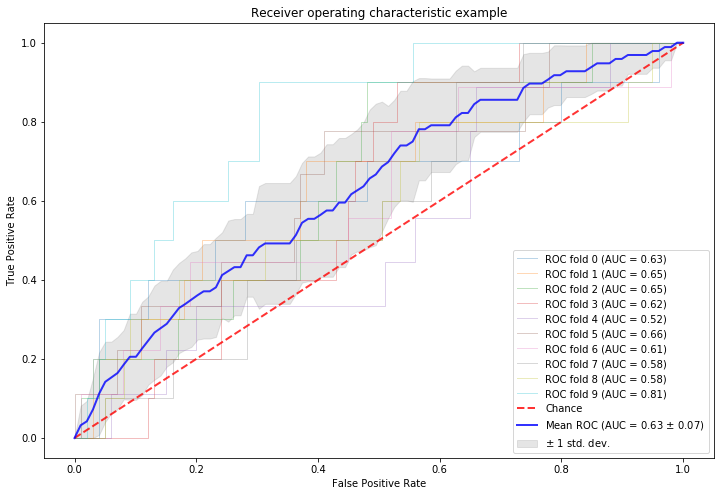

              precision    recall  f1-score   support

           0       0.98      0.62      0.76        99
           1       0.19      0.90      0.32        10

    accuracy                           0.64       109
   macro avg       0.59      0.76      0.54       109
weighted avg       0.91      0.64      0.72       109


logistic regression
[0.7090909090909091, 0.6909090909090909, 0.7090909090909091, 0.5727272727272728, 0.6788990825688074, 0.6422018348623854, 0.7247706422018348, 0.5871559633027523, 0.6513761467889908, 0.6422018348623854]
val Mean accuracy: 0.6608423686405338
val std: 0.05158727770831341


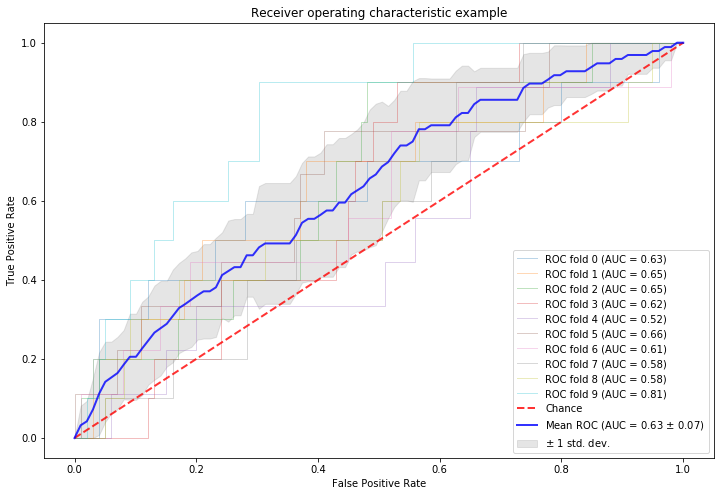

              precision    recall  f1-score   support

           0       0.98      0.62      0.76        99
           1       0.19      0.90      0.32        10

    accuracy                           0.64       109
   macro avg       0.59      0.76      0.54       109
weighted avg       0.91      0.64      0.72       109



In [243]:
def test_run():
    param_grid = {'penalty': ['l1','l2'],
              'C': np.logspace(-5, 8, 15)}
    logreg1 = LogisticRegression(dual = False, solver = 'liblinear')
    main(df, 'logistic regression', logreg1, param_grid = None, split_method = 'kfoldpipeline', stratified = True, analysis = True, PCA = False)
    print()
    main(df, 'logistic regression', logreg1, param_grid = None, split_method = 'kfold', stratified = True, analysis = True, PCA = True)
    print()
    main(df, 'logistic regression', logreg1, param_grid = None, split_method = 'kfoldtest', stratified = True,analysis = True, PCA = True)

 

test_run()

random forest
stratified kfold
[0.8909090909090909, 0.8545454545454545, 0.8818181818181818, 0.8636363636363636, 0.8532110091743119, 0.8440366972477065, 0.7522935779816514, 0.8440366972477065, 0.908256880733945, 0.908256880733945]
val Mean accuracy: 0.8601000834028357
val std: 0.04507789663423755


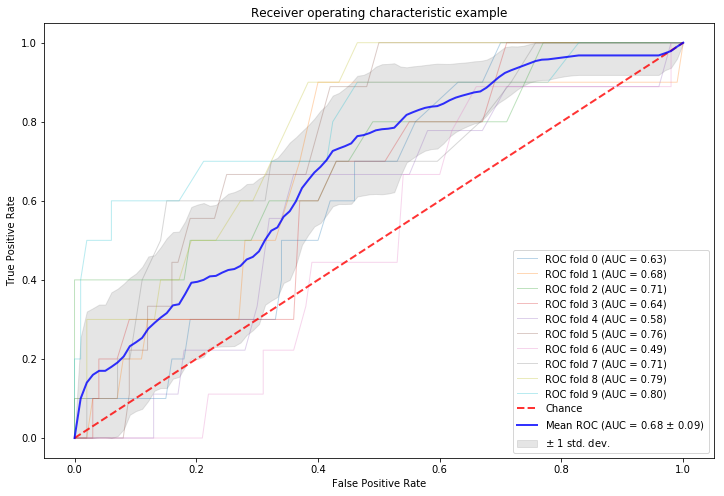

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        99
           1       0.50      0.50      0.50        10

    accuracy                           0.91       109
   macro avg       0.72      0.72      0.72       109
weighted avg       0.91      0.91      0.91       109


random forest
[0.8818181818181818, 0.8272727272727273, 0.8454545454545455, 0.8818181818181818, 0.8348623853211009, 0.8532110091743119, 0.7522935779816514, 0.8348623853211009, 0.908256880733945, 0.926605504587156]
val Mean accuracy: 0.8546455379482902
val std: 0.04901654025662606


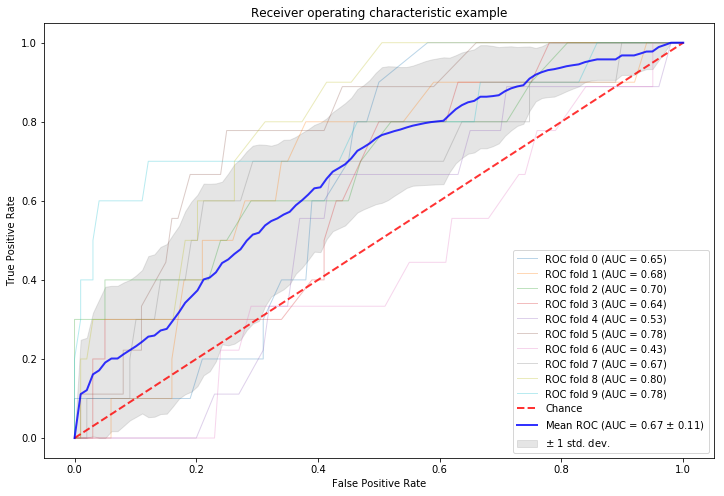

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        99
           1       0.62      0.50      0.56        10

    accuracy                           0.93       109
   macro avg       0.79      0.73      0.76       109
weighted avg       0.92      0.93      0.92       109


random forest
Pipeline: 
val Mean accuracy: 0.8637781484570476
AUC: 0.6714214809376583


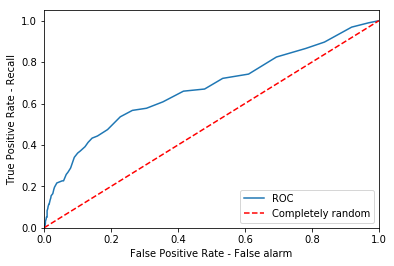

In [249]:
def test_run():
    rfc1 = RandomForestClassifier(oob_score = True,
                                  warm_start = True,
                                  criterion = 'gini',
                                  max_features = 'auto')
    svc = SVC()
    

    main(df, 'random forest', rfc1, param_grid = None, split_method = 'kfold', stratified = True, analysis = True, PCA = True)
    print()
    rfc1 = RandomForestClassifier(oob_score = True,
                                  warm_start = True,
                                  criterion = 'gini',
                                  max_features = 'auto')
    main(df, 'random forest', rfc1, param_grid = None, split_method = 'kfoldtest', stratified = True, analysis = True, PCA = False)
    print()
    rfc1 = RandomForestClassifier(oob_score = True,
                                  warm_start = True,
                                  criterion = 'gini',
                                  max_features = 'auto')
    main(df, 'random forest', rfc1, param_grid = None, split_method = 'kfoldpipeline', stratified = False, analysis = False, PCA = False)
    print()
  

test_run()

svc
stratified kfold
[0.7454545454545455, 0.7636363636363637, 0.8090909090909091, 0.6909090909090909, 0.7981651376146789, 0.8073394495412844, 0.7431192660550459, 0.7522935779816514, 0.8165137614678899, 0.8348623853211009]
val Mean accuracy: 0.776138448707256
val std: 0.04427678159803588


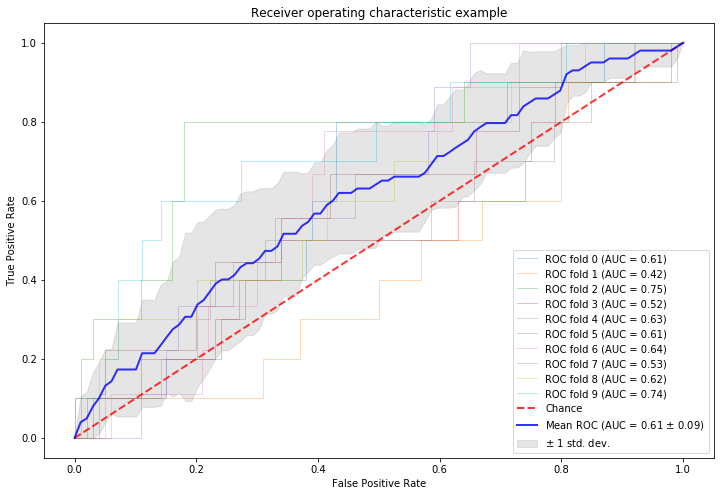

              precision    recall  f1-score   support

           0       0.96      0.86      0.90        99
           1       0.30      0.60      0.40        10

    accuracy                           0.83       109
   macro avg       0.63      0.73      0.65       109
weighted avg       0.89      0.83      0.86       109


svc
[0.7454545454545455, 0.7636363636363637, 0.8090909090909091, 0.6909090909090909, 0.7981651376146789, 0.8073394495412844, 0.7431192660550459, 0.7522935779816514, 0.8165137614678899, 0.8348623853211009]
val Mean accuracy: 0.776138448707256
val std: 0.04427678159803588


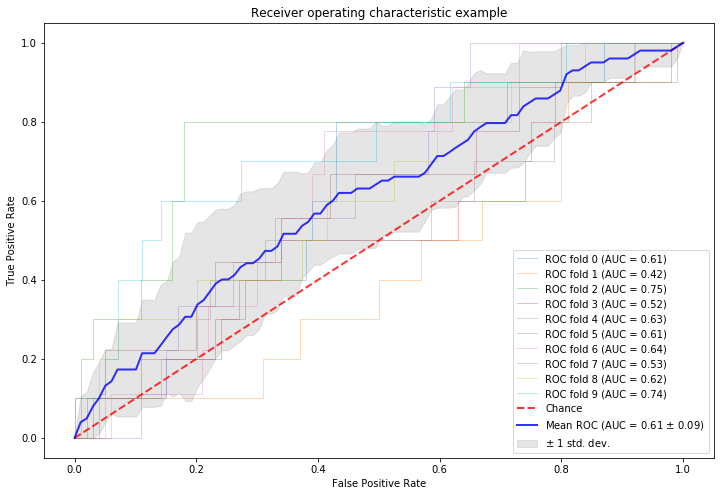

              precision    recall  f1-score   support

           0       0.96      0.86      0.90        99
           1       0.30      0.60      0.40        10

    accuracy                           0.83       109
   macro avg       0.63      0.73      0.65       109
weighted avg       0.89      0.83      0.86       109


svc
Pipeline: 
val Mean accuracy: 0.776138448707256
AUC: 0.6514491929396437


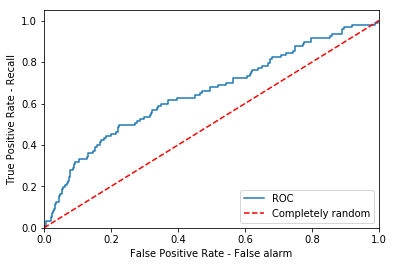

In [248]:
def test_run():

    svc = SVC()
    

    main(df, 'svc', svc, param_grid = None, split_method = 'kfold', stratified = True, analysis = True, PCA = True)
    print()
    svc = SVC(probability=True)

    main(df, 'svc', svc, param_grid = None, split_method = 'kfoldtest', stratified = True, analysis = True, PCA = False)
    print()
    svc = SVC(probability=True)
    main(df, 'svc', svc, param_grid = None, split_method = 'kfoldpipeline', stratified = False, analysis = False, PCA = False)
  

test_run()

knn
stratified kfold
[0.7363636363636363, 0.6818181818181818, 0.6636363636363637, 0.6363636363636364, 0.6330275229357798, 0.6880733944954128, 0.7339449541284404, 0.6146788990825688, 0.6146788990825688, 0.6605504587155964]
val Mean accuracy: 0.6663135946622185
val std: 0.0441871244286449


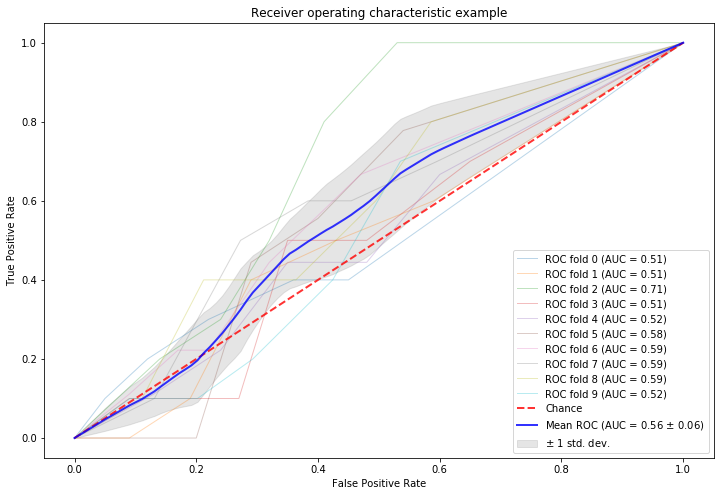

              precision    recall  f1-score   support

           0       0.90      0.71      0.79        99
           1       0.06      0.20      0.10        10

    accuracy                           0.66       109
   macro avg       0.48      0.45      0.44       109
weighted avg       0.82      0.66      0.73       109


knn
[0.7363636363636363, 0.6818181818181818, 0.6636363636363637, 0.6363636363636364, 0.6330275229357798, 0.6880733944954128, 0.7339449541284404, 0.6146788990825688, 0.6146788990825688, 0.6605504587155964]
val Mean accuracy: 0.6663135946622185
val std: 0.0441871244286449


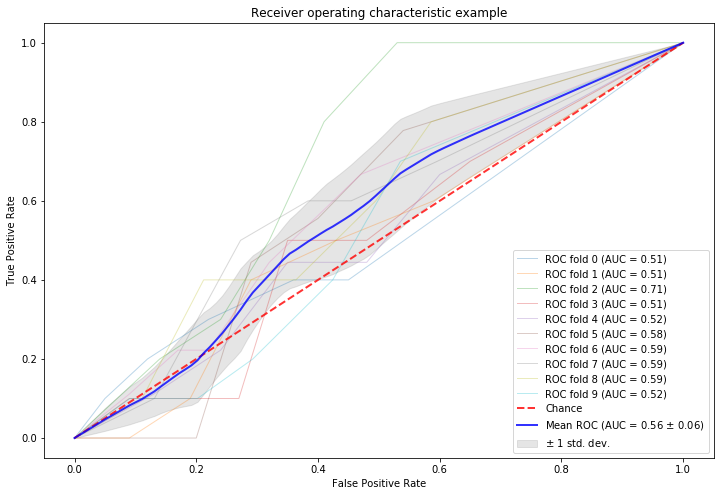

              precision    recall  f1-score   support

           0       0.90      0.71      0.79        99
           1       0.06      0.20      0.10        10

    accuracy                           0.66       109
   macro avg       0.48      0.45      0.44       109
weighted avg       0.82      0.66      0.73       109


knn
Pipeline: 
val Mean accuracy: 0.6663135946622185
AUC: 0.5682459750385176


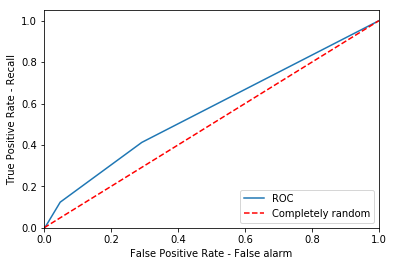

In [255]:
def test_run():

    knn = KNeighborsClassifier()
    

    main(df, 'knn', knn, param_grid = None, split_method = 'kfold', stratified = True, analysis = True, PCA = True)
    print()
    knn = KNeighborsClassifier()

    main(df, 'knn', knn, param_grid = None, split_method = 'kfoldtest', stratified = True, analysis = True, PCA = False)
    print()
    knn = KNeighborsClassifier()

    main(df, 'knn', knn, param_grid = None, split_method = 'kfoldpipeline', stratified = False, analysis = False, PCA = False)
  

test_run()

In [ ]:
# ALL X's
y = df['mental illness'].values
X = df.drop(['mental illness'],axis = 1).values
X_names = df.drop(['mental illness'],axis = 1).columns

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state = 2)
test_run()

## 1. Logistic regression
* pros:

    1. Doesn't require feature scaling
    
    
* cons:

    1. can't handle a large number of categorical features
    2. prone to overfitting
    3. perform poorly if features are correlated/similar & not correlated to y

In [ ]:
param_grid = {'penalty': ['l1','l2'],
              'C': np.logspace(-5, 8, 15)}
logreg1 = LogisticRegression(dual = False,
                             solver = 'liblinear')


logreg = LogisticRegression(dual = False,
                            solver = 'liblinear',
                            penalty = 'l1',
                            C = 0.44)

main(df, 'logistic regression', logreg, param_grid = None, split_method = 'holdout', stratified = None, analysis = False, PCA = True)

In [ ]:
main(df, 'logistic regression', logreg, param_grid = None, split_method = 'kfold', stratified = True, analysis = True, PCA = True)

main(df, 'logistic regression', logreg, param_grid = None, split_method = 'kfoldpipeline', stratified = False, analysis = False, PCA = False)



In [ ]:
# main(df, 'logistic regression', logreg, param_grid = None, split_method = 'LOO', stratified = None, analysis = None)

* LOOCV takes a long time to run given the sample size is relatively large. The result for the above line is:
    * val Mean accuracy: 0.8375
    * val std: 0.3689975760885309
* has higher variance than k-fold CV, and that it is so because the training sets in LOOCV have more overlap. This makes the estimates from different folds more dependent than in the k-fold CV, the reasoning goes, and hence increases the overall variance.

## 2. Random forest classifier
* parameters: https://www.cnblogs.com/lzhc/p/9175652.html
* pros:
    1. It does not suffer from the overfitting problem. The main reason is that it takes the average of all the predictions, which cancels out the biases.
    2. Can get the relative feature importance, which helps in selecting the most contributing features for the classifier.
* cons:
    1. Random forests is slow in generating predictions because it has multiple decision trees. 
    2. The model is difficult to interpret compared to a decision tree
* 减小特征选择个数m，树的相关性和分类能力也会相应的降低；增大m，两者也会随之增大。所以关键问题是如何选择最优的m（或者是范围），这也是随机森林唯一的一个参数 -> max_features

In [ ]:
rfc1 = RandomForestClassifier(oob_score = True,
                              warm_start = True,
                              criterion = 'gini',
                              max_features = 'auto')
param_grid = {'n_estimators': [200, 500],
              'max_depth' : [4,5,6,7,8]
             }
rfc = RandomForestClassifier(oob_score = True,
                             warm_start = True,
                             criterion = 'gini',
                             max_features = 'auto',
                             max_depth = 8,
                             n_estimators = 500)

main(df, 'random forest', rfc, param_grid = None, split_method = 'holdout', stratified = None, analysis = True, PCA = True)

* Similarly to the single decision tree, the random forest also gives a lot of importance to the “Glucose” feature, but it also chooses “BMI” to be the 2nd most informative feature overall. The randomness in building the random forest forces the algorithm to consider many possible explanations, the result being that the random forest captures a much broader picture of the data than a single tree.


* Tried removing the 4 least important features (<0.01): ['Other Hispanic','Non-Hispanic Asian','5drinks2hours','Other/Multi-racial'], does not improve accuracy

In [ ]:
main(df, 'random forest', rfc, param_grid = None, split_method = 'kfold', stratified = True, analysis = True, PCA = True)


main(df, 'random forest', rfc, param_grid = None, split_method = 'kfoldpipeline', stratified = False, analysis = False, PCA = False)


main(df, 'random forest', rfc, param_grid = None, split_method = 'kfold', stratified = True, analysis = True, PCA = True)

## 3. Decision tree

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

The accuracy on the training set is 100%, while the test set accuracy is much worse. This is an indicative that the tree is overfitting and not generalizing well to new data. Therefore, we need to apply pre-pruning to the tree.
We set max_depth=3, limiting the depth of the tree decreases overfitting. This leads to a lower accuracy on the training set, but an improvement on the test set.

In [ ]:
tree = DecisionTreeClassifier(max_depth=3, random_state=0)
# tree.fit(X_train, y_train)
# print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train)))
# print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

main(df, 'Decision tree', tree, param_grid = None, split_method = 'kfold', stratified = True, analysis = True, PCA = True)
main(df, 'Decision tree', tree, param_grid = None, split_method = 'kfoldpipeline', stratified = True, analysis = True, PCA = True)

feature_importance(X_names=X_names, fitted_clf=tree)

## 4. Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=0)
gb.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gb.score(X_train, y_train)))
print("Accuracy on val set: {:.3f}".format(gb.score(X_val, y_val)))

We are likely to be overfitting. To reduce overfitting, we could either apply stronger pre-pruning by limiting the maximum depth or lower the learning rate:

gb1 = GradientBoostingClassifier(random_state=0, max_depth=1)
gb1.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gb1.score(X_train, y_train)))
print("Accuracy on val set: {:.3f}".format(gb1.score(X_val, y_val)))

feature_importance(fitted_clf=gb1,X_names=X_names)

## 5. SVM

In [ ]:
svc = SVC()
# svc.fit(X_train, y_train)
# print("Accuracy on training set: {:.2f}".format(svc.score(X_train, y_train)))
# print("Accuracy on val set: {:.2f}".format(svc.score(X_val, y_val)))
main(df, 'svc', svc, param_grid = None, split_method = 'kfold', stratified = True, analysis = True, PCA = True)
main(df, 'svc', svc, param_grid = None, split_method = 'kfoldpipeline', stratified = False, analysis = False, PCA = False)


## 6. SMO

SMO provides a simple and optimised training algorithm for SVM. Usually, to solve complex problems quadratic programming, optimisation is applied for learning SVM, which makes computation procedures slower. SMO provides an easy way out for this problem. It divides the large problem into smaller ones and solves them separately with less memory requirement. SMO can handle a large set of data as memory requirement is linear, not quadratic.

main(df,'SVC',split_method = 'kfold')
main(df,'SVC',split_method = 'stratified kfold')
main(df,'SVC',split_method = 'holdout')

## 7. knn

main(df,'knn',split_method = 'kfold')
main(df,'knn',split_method = 'stratified kfold')
main(df,'knn',split_method = 'holdout')


## 8. Deep learning

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train, y_train)
print("Accuracy on training set: {:.2f}".format(mlp.score(X_train, y_train)))
print("Accuracy on val set: {:.2f}".format(mlp.score(X_val, y_val)))

plt.figure(figsize=(20, 5))
plt.imshow(mlp.coefs_[0], interpolation='none', cmap='viridis')
plt.yticks(range(len(X_names)), X_names)
plt.xlabel("Columns in weight matrix")
plt.ylabel("Input feature")
plt.colorbar()
print(X_names)

# if linear svc,  no analysis
main(df,'linear SVC',split_method = 'kfold')
main(df,'linear SVC',split_method = 'stratified kfold')
main(df,'linear SVC',split_method = 'holdout')